Getting the style and content images

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import IPython.display as display


base_image_path = keras.utils.get_file(
    "img.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
 "starry_night.jpg",
 origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")


575046/575046 ━━━━━━━━━━━━━━━━━━━━ 5s 8us/step
943128/943128 ━━━━━━━━━━━━━━━━━━━━ 6s 6us/step


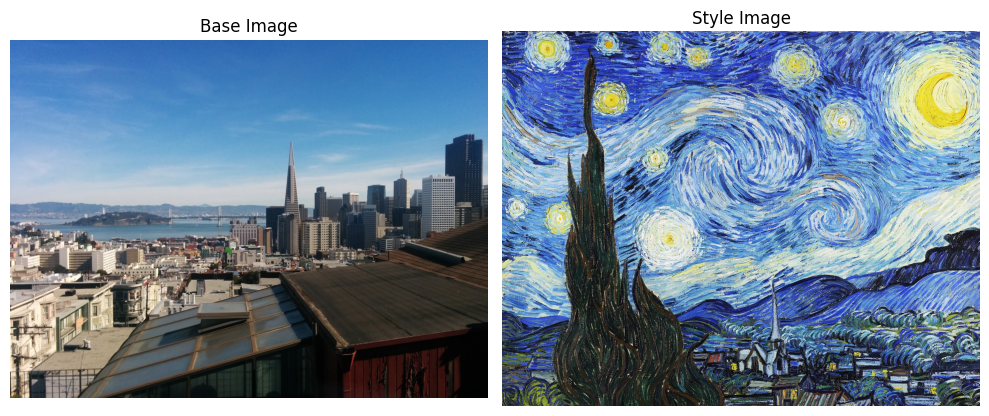

In [2]:
# Display the plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
base_image = keras.utils.load_img(base_image_path)
axes[0].imshow(base_image)
axes[0].set_title('Base Image')
axes[0].axis('off')

style_image = keras.utils.load_img(style_reference_image_path)
axes[1].imshow(style_image)
axes[1].set_title('Style Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(532.5), np.float64(399.5), np.float64(-0.5))

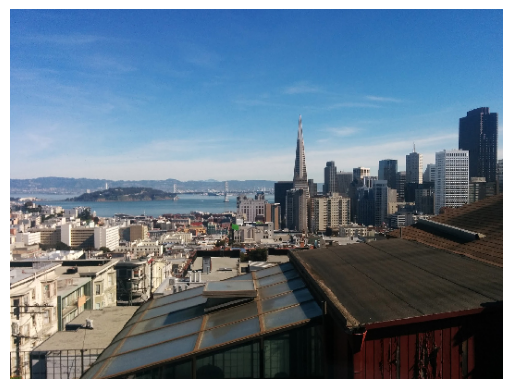

In [3]:
original_width, original_height = base_image.size
img_height = 400
img_width = round(original_width * img_height / original_height)

plt.imshow(keras.utils.load_img(base_image_path, target_size=(img_height, img_width)))
plt.axis('off')

Auxiliary functions

In [4]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path,
                        target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]  # converts images from 'BGR'->'RGB'
    img = np.clip(img, 0, 255).astype('uint8')
    return img

 Using a pretrained VGG19 model to create a feature extractor

In [5]:
model = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False)

output_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=output_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Content loss

In [6]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

Style loss

In [7]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

Total variation loss

In [8]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height -1, : img_width -1, :] - x[:, 1:, : img_width -1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [9]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
    ]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

Final loss

In [10]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
            base_image_features, combination_features)

    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
            style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

Gradient-descent process

In [11]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(
            combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [12]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

array([[[ 33,  84, 194],
        [ 27,  77, 196],
        [ 18,  63, 194],
        ...,
        [ 23,  77, 186],
        [ 26,  81, 180],
        [ 40,  96, 187]],

       [[ 23,  73, 185],
        [ 18,  68, 188],
        [ 13,  59, 189],
        ...,
        [ 12,  65, 184],
        [ 12,  65, 174],
        [ 28,  81, 184]],

       [[ 29,  79, 192],
        [ 39,  90, 204],
        [ 49,  98, 219],
        ...,
        [  9,  70, 188],
        [  0,  57, 172],
        [ 12,  65, 178]],

       ...,

       [[118, 107,  39],
        [135, 128,  53],
        [159, 155,  72],
        ...,
        [  0,  12,  22],
        [  0,   0,   5],
        [  0,   1,  19]],

       [[105,  96,  29],
        [112, 105,  33],
        [125, 120,  43],
        ...,
        [  0,   0,   5],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[101,  93,  31],
        [104,  97,  26],
        [115, 111,  32],
        ...,
        [  0,   0,  15],
        [  0,   0,   0],
        [  4,   8,  18]]], dtype=uint8)
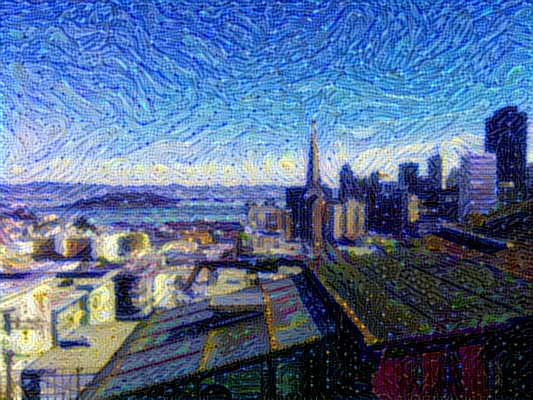

In [13]:
iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        # keras.utils.save_img(fname, img)
        display.clear_output(wait=True)
        display.display(img)